# Sklearn regression pipeline (Phase 2)

In this phase, we search for the best regression model after all input transformation are fixed.

In [1]:
%config Completer.use_jedi=False

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
from pathlib import Path
import pickle 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data import train, validation
from data import X, y, numerical, categorical
from utils import StandardizedGridSearchCV

In [7]:
# Load phase 1 Grid Search
with open('models/regression_phase_1.p', 'rb') as f:
    phase_1 = pickle.load(f)

In [8]:
train.head()

,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,...,brandID_33,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,attribute1_2,attribute1_3,attribute1_4
1404,4.850075,3.082306,4.281904,3.791205,6.480146,7.813408,1.380382,11.580054,2.201123,1.650476,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2184,2.910045,0.094506,1.709888,1.637009,0.059201,7.600842,0.000000,10.896544,1.410243,1.856786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
796,4.850075,0.217541,0.994800,1.103595,0.193577,7.016162,0.849466,11.865126,0.987170,0.866500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25,3.880060,0.327738,1.566200,1.306937,0.509315,6.876952,0.000000,10.805739,1.645284,1.624688,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1745,4.850075,0.389791,2.506703,2.351882,0.265934,8.667627,1.162427,11.653248,3.117380,1.476989,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Ridge Regression

## Iteration 1: Broad parameter search

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


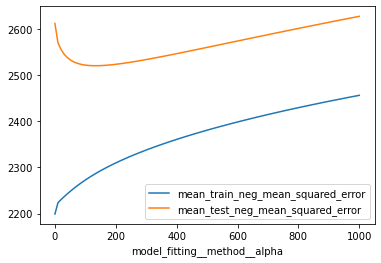

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,split5_test_neg_mean_squared_error,...,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,mean_train_r2,std_train_r2
model_fitting__method__alpha,,,,,,,,,,,,,,,,,,,,,
131.313131,3.851783,0.112877,0.012243,0.011002,-1043.839509,-1023.214850,-743.741413,-1997.000782,-1255.425175,-1250.089508,...,0.769448,0.775808,0.773817,0.771260,0.769559,0.764669,0.854406,0.763899,0.777695,0.025821
141.414141,4.012315,0.106562,0.008919,0.001549,-1042.620758,-1016.674840,-744.227311,-1996.697880,-1259.200365,-1251.623403,...,0.769090,0.775430,0.773435,0.770969,0.769224,0.764289,0.854027,0.763458,0.777315,0.025824
121.212121,3.940941,0.197349,0.008686,0.000992,-1045.350472,-1030.369443,-743.454353,-1997.295787,-1251.964202,-1248.431097,...,0.769822,0.776199,0.774214,0.771564,0.769906,0.765063,0.854799,0.764353,0.778089,0.025818
151.515152,3.952484,0.121234,0.008809,0.001936,-1041.641147,-1010.672125,-744.874406,-1996.395208,-1263.224186,-1253.048517,...,0.768746,0.775064,0.773068,0.770689,0.768899,0.763922,0.853661,0.763031,0.776949,0.025827
111.111111,3.994381,0.169828,0.008593,0.001342,-1047.221598,-1038.234052,-743.414601,-1997.571447,-1248.903809,-1246.630231,...,0.770213,0.776604,0.774627,0.771884,0.770265,0.765473,0.855208,0.764822,0.778499,0.025815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959.595960,4.010456,0.169517,0.009137,0.002028,-1061.953292,-945.618154,-836.778920,-1998.312200,-1663.836435,-1306.097552,...,0.754758,0.759058,0.757551,0.758560,0.753416,0.748696,0.838177,0.746305,0.761488,0.025926
969.696970,4.173854,0.422252,0.009211,0.001405,-1062.283663,-946.190996,-837.660364,-1998.414140,-1668.759197,-1306.619829,...,0.754644,0.758925,0.757423,0.758454,0.753279,0.748574,0.838043,0.746185,0.761362,0.025924
979.797980,4.020858,0.285412,0.007959,0.001489,-1062.612467,-946.772271,-838.535073,-1998.515285,-1673.675976,-1307.140377,...,0.754531,0.758793,0.757295,0.758348,0.753143,0.748453,0.837911,0.746067,0.761235,0.025922


In [25]:
from sklearn.linear_model import Ridge, Lasso

ridge = phase_1.best_estimator_.set_params(
    model_fitting__method = Ridge(
        max_iter = 100000,
    ),
)

ridge = StandardizedGridSearchCV(
    estimator = ridge,
    param_grid = {
        'model_fitting__method__alpha': np.linspace(0, 1000, 100),
    },
)

ridge.fit(train[X], train[y])

(-ridge.results.sort_index()[['mean_train_neg_mean_squared_error', 'mean_test_neg_mean_squared_error']]).plot()
plt.show()

ridge.results

## Iteration 2: Fine parameter search

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


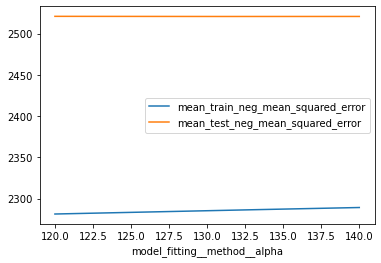

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,split5_test_neg_mean_squared_error,...,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,mean_train_r2,std_train_r2
model_fitting__method__alpha,,,,,,,,,,,,,,,,,,,,,
133.073073,3.917890,0.180969,0.008275,0.000630,-1043.607801,-1022.033526,-743.812950,-1996.948308,-1256.062415,-1250.365252,...,0.769385,0.775741,0.773749,0.771208,0.769500,0.764602,0.854339,0.763821,0.777628,0.025821
133.053053,3.940597,0.142426,0.007898,0.000303,-1043.610388,-1022.046861,-743.812103,-1996.948906,-1256.055115,-1250.362136,...,0.769386,0.775742,0.773750,0.771209,0.769500,0.764602,0.854340,0.763822,0.777628,0.025821
133.093093,3.951847,0.174906,0.008580,0.000865,-1043.605215,-1022.020194,-743.813798,-1996.947710,-1256.069717,-1250.368367,...,0.769384,0.775740,0.773749,0.771208,0.769499,0.764601,0.854338,0.763821,0.777627,0.025821
133.033033,3.903174,0.119814,0.008286,0.001033,-1043.612976,-1022.060199,-743.811257,-1996.949504,-1256.047815,-1250.359020,...,0.769386,0.775743,0.773751,0.771209,0.769501,0.764603,0.854340,0.763823,0.777629,0.025821
133.113113,3.993059,0.231733,0.008166,0.000848,-1043.602630,-1022.006863,-743.814646,-1996.947112,-1256.077020,-1250.371482,...,0.769384,0.775740,0.773748,0.771207,0.769498,0.764600,0.854337,0.763820,0.777626,0.025822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120.080080,3.549310,0.185475,0.006495,0.000383,-1045.540827,-1031.213549,-743.436571,-1997.327894,-1251.599449,-1248.236711,...,0.769865,0.776243,0.774259,0.771599,0.769945,0.765108,0.854844,0.764405,0.778134,0.025818
120.060060,3.746916,0.363583,0.006884,0.000678,-1045.544235,-1031.228558,-743.436285,-1997.328460,-1251.593044,-1248.233257,...,0.769866,0.776244,0.774260,0.771600,0.769946,0.765109,0.854845,0.764406,0.778135,0.025818
120.040040,3.697733,0.301049,0.007152,0.001206,-1045.547644,-1031.243570,-743.436000,-1997.329025,-1251.586641,-1248.229802,...,0.769867,0.776245,0.774261,0.771601,0.769947,0.765110,0.854846,0.764407,0.778136,0.025818


In [26]:
ridge = phase_1.best_estimator_.set_params(
    model_fitting__method = Ridge(
        max_iter = 100000,
    ),
)

ridge = StandardizedGridSearchCV(
    estimator = ridge,
    param_grid = {
        'model_fitting__method__alpha': np.linspace(120, 140, 1000),
    },
)

ridge.fit(train[X], train[y])

(-ridge.results.sort_index()[['mean_train_neg_mean_squared_error', 'mean_test_neg_mean_squared_error']]).plot()
plt.show()

ridge.results

In [31]:
(-ridge.results[['mean_train_neg_mean_squared_error', 'mean_test_neg_mean_squared_error']])

,mean_train_neg_mean_squared_error,mean_test_neg_mean_squared_error
model_fitting__method__alpha,,
133.073073,2286.591528,2520.873607
133.053053,2286.583738,2520.873607
133.093093,2286.599318,2520.873608
133.033033,2286.575947,2520.873608
133.113113,2286.607107,2520.873609
...,...,...
120.080080,2281.410566,2521.049941
120.060060,2281.402383,2521.050507
120.040040,2281.394199,2521.051075


## Save final tuned model

In [32]:
ridge.save('models/ridge.p')

# Lasso Regression

## Iteration 1: Broad parameter search

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2243110.365929227, tolerance: 2037.2296504016065
  model = cd_fast.enet_coordinate_descent(


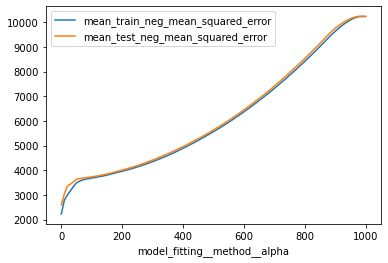

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,split5_test_neg_mean_squared_error,...,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,mean_train_r2,std_train_r2
model_fitting__method__alpha,,,,,,,,,,,,,,,,,,,,,
0.00000,8.306672,0.949412,0.011406,0.010967,-1092.965339,-1331.115302,-827.317203,-1935.861224,-1424.849771,-1228.224737,...,0.775968,0.781062,0.778781,0.777495,0.774382,0.771562,0.859677,0.771492,0.783545,0.025569
10.10101,11.075093,1.489811,0.021787,0.017037,-1192.131681,-1280.898441,-1034.020441,-1925.572127,-3303.677242,-1588.334649,...,0.724623,0.725281,0.718315,0.730485,0.722274,0.714222,0.801666,0.715605,0.728333,0.024989
20.20202,7.979694,0.337655,0.011204,0.011270,-1202.769634,-1334.618851,-1058.925290,-2094.544183,-5280.136119,-1614.899316,...,0.702816,0.699337,0.695790,0.711799,0.692671,0.700233,0.787733,0.700342,0.707747,0.027336
30.30303,10.133056,1.737455,0.019490,0.015506,-1251.786648,-1383.941544,-1119.964650,-2104.628848,-5097.427162,-1586.826584,...,0.685038,0.679308,0.694364,0.694246,0.671873,0.684851,0.769368,0.687481,0.691502,0.027238
40.40404,9.577062,1.978120,0.021277,0.023231,-1335.455256,-1486.865105,-1223.913293,-2052.361244,-4992.507759,-1596.694118,...,0.661357,0.664552,0.692599,0.669671,0.657989,0.663297,0.743122,0.669477,0.673554,0.025404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959.59596,7.890197,0.101464,0.007376,0.000393,-9000.839131,-7740.614995,-5842.188012,-8673.796793,-7064.314484,-5176.907137,...,0.010538,0.000000,0.014518,0.025173,0.000000,0.000000,0.000000,0.000000,0.007432,0.009918
969.69697,7.847890,0.090122,0.007176,0.000264,-9000.839131,-7846.498155,-5908.967972,-8673.796793,-7193.382244,-5242.250951,...,0.000000,0.000000,0.000457,0.012475,0.000000,0.000000,0.000000,0.000000,0.002425,0.004745
979.79798,9.047721,1.557009,0.025029,0.023067,-9000.839131,-7940.153350,-5908.967972,-8673.796793,-7197.595272,-5306.372367,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
from sklearn.linear_model import Lasso

lasso = phase_1.best_estimator_.set_params(
    model_fitting__method = Lasso(
        max_iter = 1000,
    ),
)

lasso = StandardizedGridSearchCV(
    estimator = lasso,
    param_grid = {
        'model_fitting__method__alpha': np.linspace(0, 1000, 100),
    },
)

lasso.fit(train[X], train[y])

(-lasso.results.sort_index()[['mean_train_neg_mean_squared_error', 'mean_test_neg_mean_squared_error']]).plot()
plt.show()

lasso.results

## Save final tuned model

We note that the best model lasso model is equivalent to standard OLS. Nonetheless, we store the model.

In [41]:
lasso.save('models/lasso.p')

# ElasticNet

We additionally consider using a mix of L1 and L2 regularization (ElasticNet) to finely control the strength of the penalty for large coefficients.

## Iteration 1: Broad parameter search

Note: log scaling is used to cover a larger parameter space.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


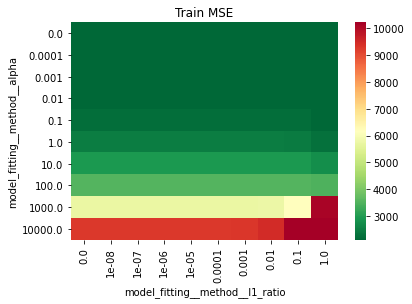

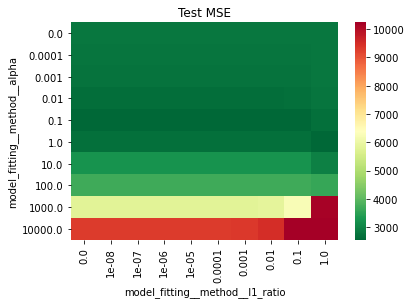

me  \
model_fitting__method__alpha model_fitting__method__l1_ratio                   
0.1                          1.000000e-09                           0.004832   
                             1.000000e-08                           0.003250   
                             1.000000e-07                           0.000698   
                             1.000000e-06                           0.000616   
                             1.000000e-05                           0.001816   
...                                                                      ...   
10000.0                      1.000000e-01                           0.001230   
100000.0                     1.000000e-02                           0.000797   
                             1.000000e-01                           0.000407   
10000.0                      1.000000e+00                           0.000680   
100000.0                     1.000000e+00                           0.000949   

                                                              split0_test_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                       
0.1                          1.000000e-09                                           -1044.198750   
                             1.000000e-08                                           -1044.198751   
                             1.000000e-07                                           -1044.198757   
                             1.000000e-06                                           -1044.198823   
                             1.000000e-05                                           -1044.199485   
...                                                                                          ...   
10000.0                      1.000000e-01                                           -8488.081704   
100000.0                     1.000000e-02                                           -8488.081704   
                             1.000000e-01                                           -8488.081704   
10000.0                      1.000000e+00                                           -8488.081704   
100000.0                     1.000000e+00                                           -8488.081704   

                                                              split1_test_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                       
0.1                          1.000000e-09                                           -1384.681672   
                             1.000000e-08                                           -1384.681672   
                             1.000000e-07                                           -1384.681672   
                             1.000000e-06                                           -1384.681678   
                             1.000000e-05                                           -1384.681729   
...                                                                                          ...   
10000.0                      1.000000e-01                                           -7274.622480   
100000.0                     1.000000e-02                                           -7274.622480   
                             1.000000e-01                                           -7274.622480   
10000.0                      1.000000e+00                                           -7274.622480   
100000.0                     1.000000e+00                                           -7274.622480   

                                                              split2_test_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                       
0.1                          1.000000e-09                                           -1237.644417   
                             1.000000e-08                                           -1237.644417   
                             1.

In [200]:
from sklearn.linear_model import ElasticNet

elasticnet = phase_1.best_estimator_.set_params(
    model_fitting__method = ElasticNet(
        selection='random', 
        max_iter = 100000,
    ),
)

elasticnet = StandardizedGridSearchCV(
    estimator = elasticnet,
    param_grid = {
        'model_fitting__method__alpha': np.logspace(-4, 5, 10),
        'model_fitting__method__l1_ratio': np.logspace(-9, 0, 10),
    },
)

elasticnet.fit(train[X], train[y])

sns.heatmap(
    -elasticnet.results.sort_index().reset_index().pivot(
        'model_fitting__method__alpha', 
        'model_fitting__method__l1_ratio', 
        'mean_train_neg_mean_squared_error',
    ),
    cmap = 'RdYlGn_r',
)
plt.title('Train MSE')
plt.show()

sns.heatmap(
    -elasticnet.results.sort_index().reset_index().pivot(
        'model_fitting__method__alpha', 
        'model_fitting__method__l1_ratio', 
        'mean_test_neg_mean_squared_error',
    ),
    cmap = 'RdYlGn_r',
)
plt.title('Test MSE')
plt.show()

elasticnet.results

From the test MSE plots, we identify (alpha=0.1, l1_ratio=1e-9) as a local optima. We will attempt to tune models at both points by further by extending the parameter space.

## Iteration 2: Fine parameter search

We revert to a linear parameter space to improve the precision of our results.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2344725.8200059696, tolerance: 2037.2296504016065
  model = cd_fast.enet_coordinate_descent(


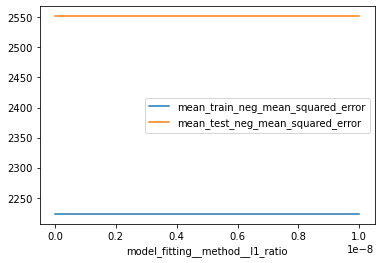

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
model_fitting__method__l1_ratio,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,44.126397,1.275832,0.011126,0.002241,-1044.198750,-1384.681672,-1237.644417,-2216.206934,-6875.166912,-2551.579737,...,0.77873,0.102231,1,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
1.010101e-10,9.822177,0.789414,0.008409,0.001656,-1044.198750,-1384.681672,-1237.644417,-2216.206934,-6875.166912,-2551.579737,...,0.77873,0.102231,2,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
2.020202e-10,11.932805,1.026762,0.009330,0.000352,-1044.198750,-1384.681672,-1237.644417,-2216.206934,-6875.166912,-2551.579737,...,0.77873,0.102231,3,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
3.030303e-10,11.881662,0.719824,0.011817,0.003993,-1044.198750,-1384.681672,-1237.644417,-2216.206934,-6875.166912,-2551.579737,...,0.77873,0.102231,4,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
4.040404e-10,11.598454,0.695059,0.009684,0.001280,-1044.198750,-1384.681672,-1237.644417,-2216.206934,-6875.166912,-2551.579737,...,0.77873,0.102231,5,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.595960e-09,9.928584,0.467726,0.009435,0.000879,-1044.198751,-1384.681672,-1237.644417,-2216.206934,-6875.166913,-2551.579737,...,0.77873,0.102231,96,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
9.696970e-09,9.801745,0.739251,0.012615,0.004526,-1044.198751,-1384.681672,-1237.644417,-2216.206934,-6875.166913,-2551.579737,...,0.77873,0.102231,97,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379
9.797980e-09,10.577441,0.810357,0.009296,0.000521,-1044.198751,-1384.681672,-1237.644417,-2216.206934,-6875.166913,-2551.579737,...,0.77873,0.102231,98,0.759032,0.771944,0.775003,0.760857,0.858881,0.785143,0.037379


In [202]:
elasticnet = phase_1.best_estimator_.set_params(
    model_fitting__method = ElasticNet(
        alpha = 0.1, # Fixed from iteration 1
        selection='random', 
        max_iter = 100000,
    ),
)

elasticnet = StandardizedGridSearchCV(
    estimator = elasticnet,
    param_grid = {
        'model_fitting__method__l1_ratio': np.linspace(0, 1e-8, 100),
    },
)

elasticnet.fit(train[X], train[y])

(-elasticnet.results.sort_index()[['mean_train_neg_mean_squared_error', 'mean_test_neg_mean_squared_error']]).plot()
plt.show()

elasticnet.results

## Save final tuned model

We note that the best model elasticnet model is equivalent to ridge regression, but performs worse than the native ridge regression model by test MSE. Nonetheless, we store the model.

In [211]:
# elasticnet.save('models/elasticnet.p')

# Validation MSE

In [34]:
from sklearn.metrics import mean_squared_error

## Un-regularized phase 1 model

In [35]:
phase_1.best_estimator_.fit(train[X], train[y])
mean_squared_error(
    y_true = validation[y],
    y_pred = phase_1.predict(validation[X])
)

1623.368488010605

## Phase 1 model with Ridge Regression

In [36]:
mean_squared_error(
    y_true = validation[y],
    y_pred = ridge.predict(validation[X])
)

1647.867402096097

## Phase 1 model with Lasso Regression

In [40]:
mean_squared_error(
    y_true = validation[y],
    y_pred = lasso.predict(validation[X])
)

1598.575216418385

## Phase 1 model with Elasticnet

In [228]:
mean_squared_error(
    y_true = validation[y],
    y_pred = elasticnet.predict(validation[X])
)

1653.6898959665414